In [26]:
import pandas as pd
import numpy as np
import  math
import requests
from bs4 import BeautifulSoup
from datetime import date, datetime, timedelta
import json
from sklearn.preprocessing import StandardScaler
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
from itertools import combinations
import matplotlib.pyplot as plt

In [21]:
def utmToLatLng(zone, easting, northing, northernHemisphere=True):
    
    if not northernHemisphere:
        northing = 10000000 - northing

    a = 6378137
    e = 0.081819191
    e1sq = 0.006739497
    k0 = 0.9996

    arc = northing / k0
    mu = arc / (a * (1 - math.pow(e, 2) / 4.0 - 3 * math.pow(e, 4) / 64.0 - 5 * math.pow(e, 6) / 256.0))

    ei = (1 - math.pow((1 - e * e), (1 / 2.0))) / (1 + math.pow((1 - e * e), (1 / 2.0)))

    ca = 3 * ei / 2 - 27 * math.pow(ei, 3) / 32.0

    cb = 21 * math.pow(ei, 2) / 16 - 55 * math.pow(ei, 4) / 32
    cc = 151 * math.pow(ei, 3) / 96
    cd = 1097 * math.pow(ei, 4) / 512
    phi1 = mu + ca * math.sin(2 * mu) + cb * math.sin(4 * mu) + cc * math.sin(6 * mu) + cd * math.sin(8 * mu)

    n0 = a / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (1 / 2.0))

    r0 = a * (1 - e * e) / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (3 / 2.0))
    fact1 = n0 * math.tan(phi1) / r0

    _a1 = 500000 - easting
    dd0 = _a1 / (n0 * k0)
    fact2 = dd0 * dd0 / 2

    t0 = math.pow(math.tan(phi1), 2)
    Q0 = e1sq * math.pow(math.cos(phi1), 2)
    fact3 = (5 + 3 * t0 + 10 * Q0 - 4 * Q0 * Q0 - 9 * e1sq) * math.pow(dd0, 4) / 24

    fact4 = (61 + 90 * t0 + 298 * Q0 + 45 * t0 * t0 - 252 * e1sq - 3 * Q0 * Q0) * math.pow(dd0, 6) / 720

    lof1 = _a1 / (n0 * k0)
    lof2 = (1 + 2 * t0 + Q0) * math.pow(dd0, 3) / 6.0
    lof3 = (5 - 2 * Q0 + 28 * t0 - 3 * math.pow(Q0, 2) + 8 * e1sq + 24 * math.pow(t0, 2)) * math.pow(dd0, 5) / 120
    _a2 = (lof1 - lof2 + lof3) / math.cos(phi1)
    _a3 = _a2 * 180 / math.pi

    latitude = 180 * (phi1 - fact1 * (fact2 + fact3 + fact4)) / math.pi

    if not northernHemisphere:
        latitude = -latitude

    longitude = ((zone > 0) and (6 * zone - 183.0) or 3.0) - _a3

    return latitude, longitude
##correcting graphics of the letters. Having different accents and definitions is better if we get all names the same

def posant_accents(it):
    
    if type(it) == str:
        
        ##lletra ç
        
        if '\x87' in it:
            nova = it.replace('\x87','ç')
        else:
            nova = it

        ###lletra i
        if '¡' or 'Ã¯'or 'ï'or 'Ã\xad'or 'í' in nova:
            renova = nova.replace('¡', 'i').replace('Ã¯', 'i').replace('ï', 'i').\
            replace('Ã\xad', 'i').replace('í', 'i')
        else:
            renova = nova
        ###Lletra o
        if '\x95' or 'Ã³' or '¢' or 'ã³'or 'Ã²' or 'ò' in renova:
            trinova = renova.replace('\x95', 'o').replace('Ã³', 'o')\
            .replace('¢', 'o').replace('ã³', 'o').replace('Ã²', 'o').replace('ò', 'o')
        else:
            trinova = renova

        if '¢' in trinova:

            quatrinova = trinova.replace('¢', 'o')
        else:
            quatrinova = trinova

        ###lletra e
        if '\x82' or 'Ã©' or 'é' or 'è'or 'Ãš' or '\x8a' in quatrinova:
            cinquinova = quatrinova.replace('\x82', 'e').replace('Ã©', 'e').replace('é', 'e').replace('è', 'e').\
            replace('Ãš', 'e').replace('\x8a', 'e')
        else:
            cinquinova = quatrinova

        if '\x85' or 'Ã\xa0'in cinquinova:
            sixinova = cinquinova.replace('\x85', 'a').replace('Ã\xa0', 'a').replace('à', 'a')
        else:
            sixinova = cinquinova

        if 'Sarr' in sixinova:

            septinova = 'Sarria'
        else:
            septinova = sixinova

        if 'Ã§' in septinova:
            vuitinova = septinova.replace('Ã§', 'ç')
        else:
            vuitinova = septinova

        ##Lletra u
        if 'ãº' or 'ú' or '£'in vuitinova:
            nounova = vuitinova.replace('ãº', 'u').replace('ú', 'u').replace('£','u')
        else:
            nounova = vuitinova

        if 'ã³' or 'ó' in nounova:

            deunova = nounova.replace('ã³', 'o').replace('ó', 'o')
        else:
            deunova = nounova
    else:
        deunova = it
    
    return deunova

####Causes a angles

def cause_to_angles(it):
    
    if it == 'Alcoholemia':
        it = 'DrunkDriving'
    if it == 'Calçada en mal estat':
        it = 'Road_damaged'
    if it == 'Drogues o medicaments':
        it = 'DUI'
    if it == 'Estat de la senyalitzacio':
        it = 'Signals_damaged'
    if it == 'Exces de velocitat o inadequada':
        it = 'Speeding'
    if it == 'Factors meteorologics':
        it = 'Weather'
    if it == 'Objectes o animals a la calçada':
        it = 'Objects or animals on the road'
    if it == 'No hi ha causa mediata':
        it = 'No mediate cause'

        
    return it

##transalting to catalan

def traduir_castella(word):
    if type(word) == str:
        if word.endswith('ismo'):
            nova = word.replace('ismo', 'isme')
        else:
            nova = word
        if 'ciclo' in nova:
            renova = nova.replace('ciclo', 'cicle')
        else:
            renova = nova
            
        if renova.startswith('Cuadri'):
            trinova = renova.replace('Cuadri', 'Quadri')
        else:
            trinova = renova
        
        if trinova.startswith('Camion'):
            
            quatrinova = trinova.replace('Camion', 'Camio rigid')
        
        else:
            quatrinova = trinova
            
        if quatrinova.endswith('  camion'):
            
            cinquinova = quatrinova.replace('camion', 'camio')
        else:
            cinquinova = quatrinova
            
        if 'Tm'in cinquinova:
            sixinova = cinquinova.replace('Tm', 'tones')
        else:
            sixinova = cinquinova
        if '75cc' in sixinova:
            septinova = sixinova.replace('75cc', ' 75 cc')
        else:
            septinova = sixinova
        if '> 75' in septinova:
            octinova = septinova.replace('> 75', '>= 75')
        else:
            octinova = septinova
        if octinova == 'Tranvia o tren':
            noninova = 'Tren o tramvia'
        else:
            noninova = octinova
        if 'de obras' in noninova:
            nova2 = noninova.replace('de obras', "d'obres i serveis")
        else:
            nova2 = noninova
        
        if 'Otros' or 'terreno' or 'articulado' or 'vehic. a' or 'Todo' or '17 plazas' in nova2:
            
            nova3 = nova2.replace('Otros', 'Altres').replace('terreno', 'terreny').\
            replace('articulado', 'articulat').replace('vehic. a', 'vehicles amb').replace('Todo', 'Tot')\
            .replace('17 plazas',' 17')
        else:
            nova3 = nova2
        if nova3 == 'Tractocamion':
            nova4 = "Tractor camio"
        else:
            nova4 = nova3
    else:
        nova4 = word
    
    return nova4

def ped_to_angles(it):
    if it == 'Desconegut':
        it = 'unknown'
    if it == 'Creuar per fora pas de vianants':
        it = 'Crossing outside ped crossing'
    if it == 'Desobeir el senyal del semafor':
        it = 'Disobey the traffic light signal'
    if it == 'Transitar a peu per la calçada':
        it = 'Cross through the road'
    if it == 'Altres':
        it = 'Other'
    if it == 'Desobeir altres senyals':
        it = 'Disobey other signals'
    if it == 'No es causa del  vianant':
        it = 'No peds fault'

        
    return it


def setmana_a_angles(it):
    if it == 'Dilluns':
        it = 'Monday'
    if it == 'Dimarts':
        it = 'Tuesday'
    if it == 'Dimecres':
        it = 'Wednesday'
    if it == 'Dijous':
        it = 'Thursday'
    if it == 'Divendres':
        it = 'Friday'
    if it == 'Dissabte':
        it = 'Saturday'
    if it == 'Diumenge':
        it = 'Sunday'
        
    return it


def mes_a_angles(it):
    if it == 'Gener':
        it = 'January'
    if it == 'Febrer':
        it = 'February'
    if it == 'Març':
        it = 'March'
    if it == 'Abril':
        it = 'April'
    if it == 'Maig':
        it = 'May'
    if it == 'Juny':
        it = 'June'
    if it == 'Juliol':
        it = 'July'
    if it == 'Agost':
        it = 'August'
    if it == 'Setembre':
        it = 'September'
    if it == 'Octubre':
        it = 'October'
    if it == 'Novembre':
        it = 'November'
    if it == 'Desembre':
        it = 'December'
        
    return it

def mes_english_number(it):
    if it == 'January':
        it = '01'
    if it == 'February':
        it = '02'
    if it == 'March':
        it = '03'
    if it == 'April':
        it = '04'
    if it == 'May':
        it = '05'
    if it == 'June':
        it = '06'
    if it == 'July':
        it = '07'
    if it == 'August':
        it = '08'
    if it == 'September':
        it = '09'
    if it == 'October':
        it = '10'
    if it == 'November':
        it = '11'
    if it == 'December':
        it = '12'
        
    return it

def counting_non_zeros(tup):
    count = 0
    for i in tup:
        if i > 0:
            count+=1
    if count == 0:
        count = 1
    return count

def debugging_strings(row, word):
    word = str(word)
    count = 0
    for i in row:
        if word in i:
            count =1
    return count

def mercedes(word):
    """Corregir tots els mercedes"""
    if word in ['mercedes-benz', 'mercedesb', 'mecedes']:
        word = 'mercedes'
    return word


def licenses(license):
    
    if 'A' in license:
        license = 'motorbike_license'
    elif 'BTP' in license:
        license = 'taxis_ambulances_license'
    elif 'B' in license:
        
        license = 'regular_license'
    elif 'D' in license:
        license = 'bus_license'
    elif 'C' in license:
        license = 'van_license'

    return license        

def fixing_codes(i):
   
    if i in desconegut_llista:
        i = int(-1)
    elif type(i) == float:
        i = int(i)
        
    elif (type(i) == str) and len(i) > 4:
        i = int(''.join(i.split("-", 2)[2:]))
    elif (type(i) == str) and len(i) <= 4:
        i = int(''.join(i.split('.')[0]))

    else:
        i = int(i)
    return i

def getting_next_day(date):
    """Adds a day to the date"""
    return (datetime.strptime(date, '%Y-%m-%d')+ timedelta(days=1)).strftime("%Y-%m-%d")
def getting_daily_weather(date):
    
    """Scrape the weather info fro barcelona during the date"""
    
    url = 'https://darksky.net/details/41.4003,2.1596/'+date+'/us12/en'
    respo = requests.get(url)
    #print('Status Code: ', respo.status_code)
    soup = BeautifulSoup(respo.content, 'lxml')
    p_s  = soup.find_all('script')[1].text
    s_s = p_s[p_s.find('['):p_s.find(']')+1]
    jdata = json.loads(s_s)
    df = pd.DataFrame(columns=[key for key in jdata[0].keys()])
    
    for x in range(0,len(jdata)):
    
        df = df.append(jdata[x]
          , ignore_index=True)
    df['time'] = df['time'].apply(lambda x: (datetime.fromtimestamp(x)+ timedelta(hours=6)).strftime('%Y-%m-%d %H:%M:%S'))
    
    return df

In [97]:
###ACCIDENTS
accidents = {}

anys = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

for an in anys:
    if int(an) < 2015:
        encoding = 'ISO-8859-15'
    else:
        encoding = 'utf-8'
    
    file = '/Users/fcbnyc/dsi/databases/BarcelonaAccidents/{}-files/{}_accidents_accidents_gu_bcn_{}.csv'.format(an, an, an)
    accidents[an] = pd.read_csv(file, encoding=encoding)
for key in accidents.keys():
    if len(accidents[key].columns) == 25:
        accidents[key].columns = ['incident_#', 'district_code', 'district', 'neighborhood_code', 'neighborhood',\
                                   'street_code', 'street', 'zip_code', 'weekday_name', 'weekday','type_of_day', 'year',\
                                    'month','month_name', 'day_month','hour_day', 'shift','pedestrian_cause','#_deaths',\
                                   'minor_injuries', 'severe_injuries','amount_victims','amount_vehicles_involved','point_y', 'point_x']
        
    else:
        accidents[key].columns = ['incident_#', 'district_code', 'district', 'neighborhood_code', 'neighborhood',\
                                   'street_code', 'street', 'zip_code', 'weekday_name', 'weekday','type_of_day', 'year',\
                                    'month','month_name', 'day_month','hour_day', 'shift','pedestrian_cause','#_deaths',\
                                    'minor_injuries', 'severe_injuries','amount_victims','amount_vehicles_involved','point_x', 'point_y',\
                                   'long', 'lat']
    accidents[key]['point_x'] = [float(x.replace(',', '.')) if type(x) == str else x for x in accidents[key]['point_x']]
    accidents[key]['point_y'] = [float(x.replace(',', '.')) if type(x) == str else x for x in accidents[key]['point_y']]
    accidents[key]['longitude'] = [b for a,b in accidents[key][['point_x', 'point_y']].apply(lambda row: utmToLatLng(31, row['point_x'], row['point_y']), axis=1)]
    accidents[key]['latitude'] = [a for a,b in accidents[key][['point_x', 'point_y']].apply(lambda row: utmToLatLng(31, row['point_x'], row['point_y']), axis=1)]


dataframe = pd.DataFrame()
prova = 0

for key in accidents.keys():
    prova = prova + len(accidents[key])
    
    dataframe = pd.concat([dataframe, accidents[key]])



dataframe = dataframe[dataframe['#_deaths'].notnull()]
dataframe.reset_index(inplace=True)
##Erasing type of day because all days are laboral
dataframe.drop(['month', 'weekday', 'type_of_day', 'point_x', 'point_y', 'lat', 'long'], axis=1, inplace=True)
dataframe = dataframe[~dataframe['incident_#'].duplicated(keep='last')]
dataframe['neighborhood'] = dataframe['neighborhood'].apply(lambda x: posant_accents(x)).replace('el Poble-sec', 'el Poble Sec')
desconegut_llista = dataframe[dataframe['neighborhood'] == 'Desconegut']['neighborhood_code'].unique()
dataframe['neighborhood_code'] = dataframe['neighborhood_code'].apply(lambda x: fixing_codes(x))
dataframe['pedestrian_cause'] = dataframe['pedestrian_cause'].apply(lambda x: posant_accents(x)).apply(lambda x: ped_to_angles(x))
dataframe['street'] = dataframe['street'].apply(lambda x: posant_accents(x))
dataframe['shift'] = ['morning' if x == 'Matí' else 'afternoon/evening' if x == 'Tarda' else 'night' if x == 'Nit' else 'watchout' for x in dataframe['shift']]
dataframe['month_name'] = dataframe['month_name'].apply(lambda x: mes_a_angles(x))
dataframe['weekday_name'] = dataframe['weekday_name'].apply(lambda x: setmana_a_angles(x))
dataframe['incident_#'] = dataframe['incident_#'].str.strip()
dataframe.to_csv('accidents_amb_2018.csv')
accidents = dataframe.copy()

print("Accidents Done")

###CAUSES

causes = {}

anys = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

for an in anys:
    if int(an) < 2015:
        encoding = 'ISO-8859-15'
    else:
        encoding = 'utf-8'
    
    file = '/Users/fcbnyc/dsi/databases/BarcelonaAccidents/{}-files/{}_accidents_causes_gu_bcn_{}.csv'.format(an, an, an)
    if int(an) == 2017:
        causes[an] = pd.read_csv(file, usecols=[0,18],encoding=encoding)
    else:
        causes[an] = pd.read_csv(file, usecols=[0,17],encoding=encoding)

dataframe = pd.DataFrame()
prova = 0

for key in causes.keys():
    prova = prova + len(causes[key])
    causes[key].columns = ['incident_#', 'cause']
    
    dataframe = pd.concat([dataframe, causes[key]])

dataframe['cause'] = dataframe['cause'].apply(lambda x: posant_accents(x)).apply(lambda x: cause_to_angles(x))
dataframe['cause'].fillna('non_existing', inplace=True)
dataframe = dataframe.groupby('incident_#').cause.agg(['count', ('cause', ','.join)]).reset_index()
dataframe.rename(columns={'count':'cause_count'}, inplace=True)
dataframe['incident_#'] = dataframe['incident_#'].str.strip()

cause_1 = []

max_count = max(dataframe['cause_count'])
for a,b in zip(dataframe['cause_count'], dataframe['cause']):
    stripped_list = b.split(',')
    added_list = ['non_existing'] * (max_count- a)
    stripped_list.extend(added_list)
    cause_1.append(stripped_list)
dataframe = pd.concat([dataframe, pd.DataFrame(cause_1, columns=['cause_1', 'cause_2', 'cause_3'])], axis=1)
dataframe.drop('cause', axis=1, inplace=True)
dataframe.to_csv('causes_amb_2018.csv')
causes = dataframe.copy()
total = pd.merge(accidents,causes, on='incident_#', how='left')
total['cause_count'].fillna(0,inplace=True)
for col in ['cause_1', 'cause_2', 'cause_3']:
    total[col].fillna('unknown', inplace=True)
causes_col_index = [total.columns.get_loc(x) for x in total.columns if x.startswith('cause') and not(x.endswith('count'))]
cause_col_names  = [x for x in total.columns if x.startswith('cause') and not(x.endswith('count'))]
causes_unique = []
for col in cause_col_names:
    for i in total[col].unique():
        causes_unique.append(i)
        
causes_unique = set(causes_unique)
for x in causes_unique:
    #column_name = '_is' + x
    total['is_cause_' + x] = [1 if x in row[causes_col_index[0]+1:causes_col_index[-1]+2]else 0 for row in total.itertuples()]

print("Causes Done")
##PeOPLe
people = {}

for an in anys:
    file = '/Users/fcbnyc/dsi/databases/BarcelonaAccidents/{}-files/{}_accidents_persones_gu_bcn_{}.csv'.format(an, an, an)
    if int(an) < 2014:
        encoding = 'ISO-8859-15'
        pont = pd.read_csv(file,encoding=encoding)
        columnes = []
        columnes.append(pont.columns[0])
        columnes.extend(pont.columns[18:22])
        people[an] = pont[columnes]
        
    elif int(an) == 2014:
        encoding = 'ISO-8859-15'
        pont = pd.read_csv(file,encoding = encoding)
        columnes = []
        columnes.append(pont.columns[0])
        columnes.extend(pont.columns[17:21])
        people[an] = pont[columnes]
        
    elif an == '2015':
        encoding = 'ISO-8859-15'
        pont = pd.read_csv(file,encoding = encoding)
        columnes = []
        columnes.append(pont.columns[0])
        columnes.extend(pont.columns[17:21])
        people[an] = pont[columnes]
        
    else:
        encoding = 'utf-8'
        pont = pd.read_csv(file, encoding = encoding)
        columnes = []
        columnes.append(pont.columns[0])
        columnes.extend(pont.columns[18:22])
        people[an] = pont[columnes]
    
    
dataframe = pd.DataFrame()
prova = 0

for key in people.keys():
    prova = prova + len(people[key])
    if int(key) < 2016:
        
        people[key].columns = ['incident_#', 'vehicle', 'gender', 'role_people', 'age']
    
    else:
        
        people[key].columns = ['incident_#', 'vehicle', 'gender', 'age', 'role_people']
    dataframe = pd.concat([dataframe, people[key]])

dataframe['gender'] = ['male' if x =='Home' else 'female' if x == 'Dona' else 'unknown' for x in dataframe['gender']]
dataframe['role_people'] = ['driver' if x =='Conductor' else 'passenger' if x == 'Passatger' else 'pedestrian' for x in dataframe['role_people']]
dataframe['vehicle'] = dataframe['vehicle'].apply(lambda x: posant_accents(x)).apply(lambda x: traduir_castella(x))
dataframe['vehicle'] = ['Motorbike' if x == 'Motocicleta' else\
 'Car' if x in ['Turisme', 'Autocaravana', 'Tot terreny'] else \
 'Moped' if x == "Ciclomotor" else \
 'Bicycle' if x == 'Bicicleta' else\
 'Bus' if x in ['Autobus', 'Autobus articulat', 'Autocar', 'Microbus <= 17'] else\
 'Van' if x == 'Furgoneta' else\
 'Truck' if x in ['Camio rigid <= 3,5 tones', 'Camio rigid > 3,5 tones', 'Tractor camio'] else 'Other vehicles' for x in dataframe['vehicle']]

dataframe = dataframe.groupby('incident_#').agg(['count',('second', ','.join)]).reset_index()
dataframe.columns = ['incident_#','people_count', 'age', 'a', 'gender', 'b', 'role_people',
                'c', 'vehicle']
dataframe.drop(['a', 'b', 'c'], axis=1,inplace=True)
dataframe['incident_#'] = dataframe['incident_#'].str.strip()
for col in dataframe.columns[2:]:   
    people_1 = []

    max_count = max(dataframe['people_count'])
    for a,b in zip(dataframe['people_count'], dataframe[col]):
        stripped_list = str(b).split(',')
        stripped_list.extend(['non_existing'] * (max_count- a))
        people_1.append(stripped_list)
    #print(col)
    dataframe = pd.concat([dataframe, pd.DataFrame(people_1, columns=[col +'_' +str(x) for x in range(1,max_count + 1)])], axis=1)
    dataframe.drop(col,axis=1,inplace=True)

dataframe.to_csv('people_amb_2018.csv')
        
people = dataframe.copy()

total = pd.merge(total,people, on='incident_#', how='left')
for col in [x for x in total.columns if x.startswith('people') and not(x.endswith('count'))]:
    total[col].fillna('non_existing', inplace=True)
for col in [x for x in total.columns if (x.startswith('role')) or (x.startswith('gender')) or (x.startswith('vehicle_'))]:
    total[col].fillna('non_existing', inplace=True)
    total[col] = [str(x).replace('0', 'non_existing') for x in total[col]]
    total[col] = [str(x).replace('0','non_existing').replace('0','Desconegut') for x in total[col]]
for col in total.columns:
    total[col].fillna('0',inplace=True)
    
vehicle_col_names = [x for x in total.columns if x.startswith('vehicle_')]
llista_vehicles = []
for col in vehicle_col_names:
    for i in total[col].unique():
        if i not in llista_vehicles:
            llista_vehicles.append(i)
total['is_vehicle_unknown'] =[1 if x in ['non_existing', 'unknown'] else 0 for x in total['vehicle_1']]
llista_vehicles.remove('non_existing')

for i in llista_vehicles:
    total['is_vehicle_' + i] = [debugging_strings(row[1:],i) for row in total[vehicle_col_names].itertuples()]

roles_col_names = [x for x in total.columns if 'role' in x]
for role in total['role_people_1'].unique():
    total['is_role_' + role] = [debugging_strings(row[1:], role) for row in total[roles_col_names].itertuples()]
        
age_col_names = [x for x in total.columns if x.startswith('age_')]
age_col_index = [total.columns.get_loc(x) for x in total.columns if x.startswith('age_')]

for col in age_col_names:
    total[col] = [str(x).replace('non_existing', '0').replace('Desconegut', '0') for x in total[col]]
    total[col] = total[col].astype(int)

total['age_avg'] = [sum(row[age_col_index[0] +1:age_col_index[-1] + 2])/counting_non_zeros(row[age_col_index[0] +1:age_col_index[-1] + 2])\
                    for row in total.itertuples()]
age_role_col_names = [x for x in total.columns if ('age_' in x )or ('role_' in x)]
gender_role_col_index = [total.columns.get_loc(x) for x in total.columns if ('age_' in x )or ('role_' in x)]
age_driver = []
is_young_driver = []
for row in total[age_role_col_names].itertuples():
    age = 0
    count = 0
    young = 0
    for x in range(0,len(row)):
        if row[x] == 'driver':
            count=count + 1
            age = age + row[x-21]
            if row[x-21] <25:
                young = young + 1
    if count == 0:
        age_driver.append(count)
    else:
        age_driver.append(age/count)
    if young >0:
        is_young_driver.append(young)
    else:
        is_young_driver.append(young) 

total['age_driver'] = age_driver
total['is_young_driver'] = is_young_driver

gender_role_col_names = [x for x in total.columns if ('gender_' in x )or ('role_' in x)]
 
gender_role_col_index = [total.columns.get_loc(x) for x in total.columns if ('age_' in x )or ('role_' in x)]
is_female_driver = []
is_male_driver = []
for row in total[gender_role_col_names].itertuples():
    is_male = 0
    is_female = 0
    count = 0
    for x in range(0,len(row)):
        if row[x] == 'driver':
            if row[x-21] == 'male':
                is_male +=1
            if row[x-21] == 'female':
                is_female +=1
            

    is_male_driver.append(is_male)
    is_female_driver.append(is_female)

            
total['is_male_driver'] = is_male_driver
total['is_female_driver'] = is_female_driver

print("People Done")

##TYPES

types = {}

anys = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

for an in anys:
    if int(an) < 2016:
        encoding = 'ISO-8859-15'
    else:
        encoding = 'utf-8'
    
    file = '/Users/fcbnyc/dsi/databases/BarcelonaAccidents/{}-files/{}_accidents_tipus_gu_bcn_{}.csv'.format(an, an, an)
        
    types[an] = pd.read_csv(file, usecols=[0,17],encoding=encoding)
    

dataframe = pd.DataFrame()
prova = 0

for key in types.keys():
    prova = prova + len(types[key])
    types[key].columns = ['incident_#', 'accident_type']
    
    dataframe = pd.concat([dataframe, types[key]])
    
dataframe['accident_type'] = dataframe['accident_type'].apply(lambda x: posant_accents(x)).map({'Atropellament': 'run_over',
                                                              'Col.lisio lateral': 'lateral_collision',
                                                              'Xoc contra element estatic': 'crash_into_stationary',
                                                              'Abast': 'rear-end_collision',
                                                               'Col.lisio frontal':'frontal_collision',
                                                              'Col.lisio fronto-lateral':'frontal-lateral_collision',
                                                              'Caiguda (dues rodes)':'fall--motorcycle',
                                                              'Abast multiple':'multiple_rear-end_collision',
                                                              'Caiguda interior vehicle':'fall_inside_vehicle',
                                                              'Altres':'Other_types',
                                                              'Bolcada (mes de dues rodes)':'overturning',
                                                              'Desconegut':'unknown',
                                                              'Sortida de via amb xoc o col.lisio':'run-off_with_crash_or_collision',
                                                              'Encalç':'rear-end_collision',
                                                              'Sortida de via amb bolcada':'run-off_with_overturning',
                                                              'Xoc amb animal a la calçada':'crash_into_animal_on_road',
                                                              'Resta sortides de via':'run-off_not_included_previously'})

dataframe = dataframe.groupby('incident_#').agg(['count',('type_count', ','.join)]).reset_index()

dataframe.columns = ['incident_#', 'type_count', 'accident_type']
dataframe['incident_#'] = dataframe['incident_#'].str.strip()

for col in dataframe.columns[2:]:   
    people_1 = []

    max_count = max(dataframe['type_count'])
    for a,b in zip(dataframe['type_count'], dataframe[col]):
        stripped_list = str(b).split(',')
        stripped_list.extend([0] * (max_count- a))
        people_1.append(stripped_list)
    #print(col)
    dataframe = pd.concat([dataframe, pd.DataFrame(people_1, columns=[col + '_'+ str(x) for x in range(1,max_count + 1)])], axis=1)
    dataframe.drop(col,axis=1,inplace=True)

dataframe.to_csv('types_amb_2018.csv')
types = dataframe.copy()
total = pd.merge(total,types, on='incident_#', how='left')
type_col_index = [total.columns.get_loc(x) for x in total.columns if 'type' in x]
type_col_names  = [x for x in total.columns if 'type' in x]
total['type_count'].fillna(0,inplace=True)
total['accident_type_1'].fillna('unknown',inplace=True)
total['accident_type_1'] = [str(x).replace('0', 'unknown') for x in total['accident_type_1']]
for col in type_col_names[2:]:
    total[col] = [str(x).replace('0', 'non_existing').replace('nan', 'non_existing') for x in total[col]]
    total[col].fillna('non_existing',inplace=True)
                                
                            
total.fillna('non_existing',inplace=True)

for i in total['accident_type_1'].value_counts().index:
    if total['accident_type_1'].value_counts()[i] > 200:
        total['is_type_' + i] = [debugging_strings(row[2:5],i) for row in total[type_col_names].itertuples()]

print("Types Done")

###VEHICLES

vehicles = {}

anys = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

for an in anys:
    if int(an) < 2016:
        encoding = 'ISO-8859-15'
    else:
        encoding = 'utf-8'
    
    file = '/Users/fcbnyc/dsi/databases/BarcelonaAccidents/{}-files/{}_accidents_vehicles_gu_bcn_{}.csv'.format(an, an, an)
        
    if an != '2018':
        pont = pd.read_csv(file, encoding=encoding)
        columnes = []
        columnes.append(pont.columns[0])
        columnes.extend(pont.columns[18:23])
        vehicles[an] = pont[columnes]
    else:
        pont = pd.read_csv(file, encoding=encoding)
        columnes = []
        columnes.append(pont.columns[0])
        columnes.extend(pont.columns[19:24])
        vehicles[an] = pont[columnes]
    

dataframe = pd.DataFrame()
prova = 0

for key in vehicles.keys():
    prova = prova + len(vehicles[key])
    vehicles[key].columns = ['incident_#', 'vehicle_model', 'vehicle_brand', "vehicle_color", 'license_class', 'senority_license']
    
    dataframe = pd.concat([dataframe, vehicles[key]])
dataframe['vehicle_color'] = dataframe['vehicle_color'].apply(lambda x: posant_accents(x)).map({'Negre': 'black',
                                                              'Blanc': 'white', 'Altres':'others', 'Gris': 'gray',
                                                              'Vermell': 'red', 'Blau':'blue','Verd': 'green',
                                                              'Platejat': 'silver','Groc': 'yellow','Beige':'beige',
                                                              'Marro':'brown','Taronja':'orange','Daurat':'gold',
                                                              'Violeta':'purple','Rosa':'pink', 'Negre/Groc':'black/yellow',
                                                              'granate':'maroon'})
dataframe['vehicle_color'].fillna('unknown',inplace=True)
dataframe['vehicle_model'].fillna('unknown',inplace=True)
dataframe = dataframe[dataframe['incident_#'].notnull()]
dataframe['senority_license'] = dataframe['senority_license'].replace('Desconegut', '0')
dataframe['license_class'].replace(['Desconegut', 'Es desconeix'], 'unknown',inplace=True)
dataframe['vehicle_model'].replace('Desconegut', 'unknown',inplace=True)
dataframe['vehicle_brand'].replace('Desconegut', 'unknown',inplace=True)
dataframe = dataframe.groupby('incident_#').agg(['count',('vehicle_count', ','.join)]).reset_index()
dataframe.columns = ['incident_#', 'vehicle_count', 'vehicle_model', 'a',
                    'vehicle_brand', 'b', 'vehicle_color', 'c', 'license_class', 'd', 'senority_license']
dataframe.drop(['a','b','c', 'd'], axis=1, inplace=True)
dataframe['incident_#'] = dataframe['incident_#'].str.strip()
dataframe['vehicle_model'] = [s.replace(',', '') for s in dataframe['vehicle_model']]
for col in dataframe.columns[2:]:   
    people_1 = []

    max_count = max(dataframe['vehicle_count'])
    for a,b in zip(dataframe['vehicle_count'], dataframe[col]):
        stripped_list = str(b).split(',')
        stripped_list.extend([0] * (max_count- a))
        people_1.append(stripped_list)
        #print(len(stripped_list))
    #print(col)
    dataframe = pd.concat([dataframe, pd.DataFrame(people_1, columns=[col +'_' +str(x) for x in range(1,max_count + 1)])], axis=1)
    dataframe.drop(col,axis=1,inplace=True)
    
dataframe.to_csv('vehicles_amb_2018.csv')

vehicles = dataframe.copy()
total = pd.merge(total,vehicles, on='incident_#', how='left')
for col in [x for x in total.columns if (x.startswith('vehicle_brand')) or (x.startswith('vehicle_color'))]:
    total[col] = total[col].str.replace('0', 'non_existing')
    total[col] = [str(x).lower().strip().replace('.','').replace(' ', '') for x in total[col]]
    total[col].fillna('non_existing',inplace=True)
for col in total.columns:
    total[col].fillna(0,inplace=True)
##not using model because has too many unique values
vehicle_brand_col_names = [x for x in total.columns if x.startswith('vehicle_brand_')]
for col in vehicle_brand_col_names:
    total[col] = total[col].apply(lambda x: mercedes(x))
    total[col] = total[col].str.replace('nan', 'non_existing')
for x in total['vehicle_brand_1'].value_counts()[0:20].index:
    total['is_vehicle_brand_' + x] = [debugging_strings(row[1:],x) for row in total[vehicle_brand_col_names].itertuples()]
vehicle_color_col_names = [x for x in total.columns if x.startswith('vehicle_color_')]
for col in vehicle_color_col_names:
    total[col] = total[col].str.replace('nan','unknown')
for x in total['vehicle_color_1'].value_counts().index:
    total['is_vehicle_color_' + x] = [debugging_strings(row[1:],x) for row in total[vehicle_color_col_names].itertuples()]

vehicle_license_col_names = [x for x in total.columns if x.startswith('license_class')]
for col in vehicle_license_col_names:
    total[col] = total[col].apply(lambda x: posant_accents(x))
    total[col] =total[col].str.replace('0', 'non-existing').replace('Sense permis','no_license').\
    replace('Llicencia', 'moped_permit').replace('AM', 'moped_permit')
    total[col].fillna('non-existing',inplace=True)
    total[col] = total[col].apply(lambda x: licenses(x))
    
for i in total['license_class_1'].unique():
    total['is_license_class_' + i] = [debugging_strings(row[1:],i) for row in total[vehicle_license_col_names].itertuples()]

senority_col_names = [x for x in total.columns if x.startswith('senority_')]
for col in senority_col_names:
    total[col] = [str(x).replace('non_existing', '0').replace('Desconegut', '0') for x in total[col]]
    total[col] = total[col].astype(int)

total['senority_avg'] = [sum(row[1:])/counting_non_zeros(row[1:])\
                    for row in total[senority_col_names].itertuples()]
total.to_csv('total_accidents_2018.csv', encoding='utf-8')    

print('DONE')

# print(total.isnull().sum().sum())
# total.to_csv('total_accidents_2018.csv', encoding='utf-8')
##Stripping all values
# total_obj = total.select_dtypes(['object'])
# total[total_obj.columns] = total_obj.apply(lambda x: x.str.strip())
##Next step is to create a column for cause, people, types and vehicles
##creating columns for:
# Number of each gender
#mean age of driversDONE
#gender of driversDONE



Accidents Done
Causes Done
People Done
Types Done
DONE


In [76]:
total.to_csv('total_accidents_2018.csv', encoding='utf-8')

## Scraping weather 2010
### Due ti the limit on the amount of data to request. I xplitted the eforts in years

In [8]:
weather_list = []

In [224]:
import requests
from bs4 import BeautifulSoup
from datetime import date, datetime, timedelta


def getting_next_day(date):
    """Adds a day to the date"""
    return (datetime.strptime(date, '%Y-%m-%d')+ timedelta(days=1)).strftime("%Y-%m-%d")
def getting_daily_weather(date):
    
    """Scrape the weather info fro barcelona during the date"""
    
    url = 'https://darksky.net/details/41.4003,2.1596/'+date+'/us12/en'
    respo = requests.get(url)
    #print('Status Code: ', respo.status_code)
    soup = BeautifulSoup(respo.content, 'lxml')
    p_s  = soup.find_all('script')[1].text
    s_s = p_s[p_s.find('['):p_s.find(']')+1]
    jdata = json.loads(s_s)
    df = pd.DataFrame(columns=[key for key in jdata[0].keys()])

    for x in range(0,len(jdata)):
    
        df = df.append(jdata[x]
          , ignore_index=True)
    df['time'] = df['time'].apply(lambda x: (datetime.fromtimestamp(x)+ timedelta(hours=6)).strftime('%Y-%m-%d %H:%M:%S'))
    
    return df
df_total = []

number_of_days = 366
date = '2010-01-01'
count = 1
while count <= number_of_days:
    #print(date)
    df = getting_daily_weather(date)
    df_total.append(df)
    date = getting_next_day(date)
    count = count + 1
    if count % 10 == 0:
        print(count)
        print(date)
final_df = pd.concat(df_total,ignore_index=True)
final_df['time'][-1:], len(final_df)
weather_2010 = final_df[pd.to_datetime(final_df['time']).dt.year ==2010].copy()
weather_2010.to_csv('weather2010.csv')

10
2010-01-10
20
2010-01-20
30
2010-01-30
40
2010-02-09
50
2010-02-19
60
2010-03-01
70
2010-03-11
80
2010-03-21
90
2010-03-31
100
2010-04-10
110
2010-04-20
120
2010-04-30
130
2010-05-10
140
2010-05-20
150
2010-05-30
160
2010-06-09
170
2010-06-19
180
2010-06-29
190
2010-07-09
200
2010-07-19
210
2010-07-29
220
2010-08-08
230
2010-08-18
240
2010-08-28
250
2010-09-07
260
2010-09-17
270
2010-09-27
280
2010-10-07
290
2010-10-17
300
2010-10-27
310
2010-11-06
320
2010-11-16
330
2010-11-26
340
2010-12-06
350
2010-12-16
360
2010-12-26


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(8782    2011-01-01 23:00:00
 Name: time, dtype: object, 8783)

In [9]:
weather_2010 = pd.read_csv('weather2010.csv')
weather_list.append(weather_2010)

## Scraping weather 2011-12

In [299]:
df_total = []
year = 2011
number_of_days = 735
date = '2011-01-01'
count = 1
while count <= number_of_days:
    #print(date)
    df = getting_daily_weather(date)
    df_total.append(df)
    date = getting_next_day(date)
    count = count + 1
    if count % 10 == 0:
        print(count)
        print(date)
final_df = pd.concat(df_total,ignore_index=True)
final_df['time'][-1:], len(final_df)
weather_2011_12 = final_df[(pd.to_datetime(final_df['time']).dt.year ==2011) | (pd.to_datetime(final_df['time']).dt.year ==2012)].copy()
weather_2011_12.to_csv('weather2011_12.csv')
weather_2011_12.tail()

10
2011-01-10
20
2011-01-20
30
2011-01-30
40
2011-02-09
50
2011-02-19
60
2011-03-01
70
2011-03-11
80
2011-03-21
90
2011-03-31
100
2011-04-10
110
2011-04-20
120
2011-04-30
130
2011-05-10
140
2011-05-20
150
2011-05-30
160
2011-06-09
170
2011-06-19
180
2011-06-29
190
2011-07-09
200
2011-07-19
210
2011-07-29
220
2011-08-08
230
2011-08-18
240
2011-08-28
250
2011-09-07
260
2011-09-17
270
2011-09-27
280
2011-10-07
290
2011-10-17
300
2011-10-27
310
2011-11-06
320
2011-11-16
330
2011-11-26
340
2011-12-06
350
2011-12-16
360
2011-12-26
370
2012-01-05
380
2012-01-15
390
2012-01-25
400
2012-02-04
410
2012-02-14
420
2012-02-24
430
2012-03-05
440
2012-03-15
450
2012-03-25
460
2012-04-04
470
2012-04-14
480
2012-04-24
490
2012-05-04
500
2012-05-14
510
2012-05-24
520
2012-06-03
530
2012-06-13
540
2012-06-23
550
2012-07-03
560
2012-07-13
570
2012-07-23
580
2012-08-02
590
2012-08-12
600
2012-08-22
610
2012-09-01
620
2012-09-11
630
2012-09-21
640
2012-10-01
650
2012-10-11
660
2012-10-21
670
2012-10-31
680


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,solar,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
8755,56.14,0.19,44.9,0.66,partly-cloudy-night,NaN,0,0,NaN,1023.92,NaN,Partly Cloudy,56.14,2011-12-31 19:00:00,0,6.216,336,6.7,2.4
8756,56.24,0.19,45.19,0.66,partly-cloudy-night,NaN,0,0,NaN,1024.01,NaN,Partly Cloudy,56.24,2011-12-31 20:00:00,0,6.216,333,5.79,3.46
8757,55.72,0.19,44.81,0.67,partly-cloudy-night,NaN,0,0,NaN,1024.52,NaN,Partly Cloudy,55.72,2011-12-31 21:00:00,0,6.216,316,4.11,2.77
8758,55.49,0.19,45.29,0.68,partly-cloudy-night,NaN,0,0,NaN,1024.52,NaN,Partly Cloudy,55.49,2011-12-31 22:00:00,0,6.216,297,6.83,2.05
8759,54.93,0.19,45.16,0.70,partly-cloudy-night,NaN,0,0,NaN,1024.42,NaN,Partly Cloudy,54.93,2011-12-31 23:00:00,0,6.216,311,4.85,1.93


In [10]:
weather_2011_12 = pd.read_csv('weather2011_12.csv')
weather_list.append(weather_2011_12)
len(weather_list)

2

In [341]:
## Weather 2013-14
df_total = []
#year = 2011
number_of_days = 735
date = '2013-01-01'
count = 1
while count <= number_of_days:
    #print(date)
    df = getting_daily_weather(date)
    df_total.append(df)
    date = getting_next_day(date)
    count = count + 1
    if count % 10 == 0:
        print(count)
        print(date)
final_df = pd.concat(df_total,ignore_index=True)
final_df['time'][-1:], len(final_df)
weather_2013_14 = final_df[(pd.to_datetime(final_df['time']).dt.year ==2013) | (pd.to_datetime(final_df['time']).dt.year ==2014)].copy()
weather_2013_14.to_csv('weather2013_14.csv')
weather_list.append(weather_2013_14)
weather_2013_14.tail()

10
2013-01-10
20
2013-01-20
30
2013-01-30
40
2013-02-09
50
2013-02-19
60
2013-03-01
70
2013-03-11
80
2013-03-21
90
2013-03-31
100
2013-04-10
110
2013-04-20
120
2013-04-30
130
2013-05-10
140
2013-05-20
150
2013-05-30
160
2013-06-09
170
2013-06-19
180
2013-06-29
190
2013-07-09
200
2013-07-19
210
2013-07-29
220
2013-08-08
230
2013-08-18
240
2013-08-28
250
2013-09-07
260
2013-09-17
270
2013-09-27
280
2013-10-07
290
2013-10-17
300
2013-10-27
310
2013-11-06
320
2013-11-16
330
2013-11-26
340
2013-12-06
350
2013-12-16
360
2013-12-26
370
2014-01-05
380
2014-01-15
390
2014-01-25
400
2014-02-04
410
2014-02-14
420
2014-02-24
430
2014-03-06
440
2014-03-16
450
2014-03-26
460
2014-04-05
470
2014-04-15
480
2014-04-25
490
2014-05-05
500
2014-05-15
510
2014-05-25
520
2014-06-04
530
2014-06-14
540
2014-06-24
550
2014-07-04
560
2014-07-14
570
2014-07-24
580
2014-08-03
590
2014-08-13
600
2014-08-23
610
2014-09-02
620
2014-09-12
630
2014-09-22
640
2014-10-02
650
2014-10-12
660
2014-10-22
670
2014-11-01
680


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


NameError: name 'weahter_list' is not defined

In [12]:
weather_2013_14 = pd.read_csv('weather2013_14.csv')
weather_list.append(weather_2013_14)
len(weather_list)

3

In [32]:
## Weather 2015-16
df_total = []
#year = 2011
number_of_days = 735
date = '2015-01-01'
count = 1
while count <= number_of_days:
    #print(date)
    df = getting_daily_weather(date)
    df_total.append(df)
    date = getting_next_day(date)
    count = count + 1
    if count % 10 == 0:
        print(count)
        print(date)
final_df = pd.concat(df_total,ignore_index=True)
final_df['time'][-1:], len(final_df)
weather_2015_16 = final_df[(pd.to_datetime(final_df['time']).dt.year ==2015) | (pd.to_datetime(final_df['time']).dt.year ==2016)].copy()
weather_2015_16.to_csv('weather2015_16.csv')
weather_list.append(weather_2015_16)
weather_2015_16.tail()

10
2015-01-10
20
2015-01-20
30
2015-01-30
40
2015-02-09
50
2015-02-19
60
2015-03-01
70
2015-03-11
80
2015-03-21
90
2015-03-31
100
2015-04-10
110
2015-04-20
120
2015-04-30
130
2015-05-10
140
2015-05-20
150
2015-05-30
160
2015-06-09
170
2015-06-19
180
2015-06-29
190
2015-07-09
200
2015-07-19
210
2015-07-29
220
2015-08-08
230
2015-08-18
240
2015-08-28
250
2015-09-07
260
2015-09-17
270
2015-09-27
280
2015-10-07
290
2015-10-17
300
2015-10-27
310
2015-11-06
320
2015-11-16
330
2015-11-26
340
2015-12-06
350
2015-12-16
360
2015-12-26
370
2016-01-05
380
2016-01-15
390
2016-01-25
400
2016-02-04
410
2016-02-14
420
2016-02-24
430
2016-03-05
440
2016-03-15
450
2016-03-25
460
2016-04-04
470
2016-04-14
480
2016-04-24
490
2016-05-04
500
2016-05-14
510
2016-05-24
520
2016-06-03
530
2016-06-13
540
2016-06-23
550
2016-07-03
560
2016-07-13
570
2016-07-23
580
2016-08-02
590
2016-08-12
600
2016-08-22
610
2016-09-01
620
2016-09-11
630
2016-09-21
640
2016-10-01
650
2016-10-11
660
2016-10-21
670
2016-10-31
680


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,precipType,pressure,solar,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
17539,50.51,0,44.08,0.79,clear-night,0,0,NaN,NaN,NaN,Clear,50.51,2016-12-31 19:00:00,0,6.216,359,1.45,0.57
17540,49.14,0,42.39,0.77,clear-night,0,0,NaN,NaN,NaN,Clear,49.14,2016-12-31 20:00:00,0,6.216,295,1.43,0.62
17541,46.91,0,40.58,0.79,clear-night,0,0,NaN,NaN,NaN,Clear,46.91,2016-12-31 21:00:00,0,6.216,328,1.14,0.84
17542,45.62,0,39.81,0.80,clear-night,0,0,NaN,NaN,NaN,Clear,45.62,2016-12-31 22:00:00,0,6.216,294,2.6,1.07
17543,44.8,0,38.69,0.79,clear-night,0,0,NaN,NaN,NaN,Clear,44.8,2016-12-31 23:00:00,0,6.216,282,2.69,0.65


In [49]:
## Weather 2017-18
df_total = []
#year = 2011
number_of_days = 735
date = '2017-01-01'
count = 1
while count <= number_of_days:
    #print(date)
    df = getting_daily_weather(date)
    df_total.append(df)
    date = getting_next_day(date)
    count = count + 1
    if count % 10 == 0:
        print(count)
        print(date)
final_df = pd.concat(df_total,ignore_index=True)
final_df['time'][-1:], len(final_df)
weather_2017_18 = final_df[(pd.to_datetime(final_df['time']).dt.year ==2017) | (pd.to_datetime(final_df['time']).dt.year ==2018)].copy()
weather_2017_18.to_csv('weather2017_18.csv')
weather_list.append(weather_2017_18)
weather_2017_18.tail()

10
2017-01-10
20
2017-01-20
30
2017-01-30
40
2017-02-09
50
2017-02-19
60
2017-03-01
70
2017-03-11
80
2017-03-21
90
2017-03-31
100
2017-04-10
110
2017-04-20
120
2017-04-30
130
2017-05-10
140
2017-05-20
150
2017-05-30
160
2017-06-09
170
2017-06-19
180
2017-06-29
190
2017-07-09
200
2017-07-19
210
2017-07-29
220
2017-08-08
230
2017-08-18
240
2017-08-28
250
2017-09-07
260
2017-09-17
270
2017-09-27
280
2017-10-07
290
2017-10-17
300
2017-10-27
310
2017-11-06
320
2017-11-16
330
2017-11-26
340
2017-12-06
350
2017-12-16
360
2017-12-26
370
2018-01-05
380
2018-01-15
390
2018-01-25
400
2018-02-04
410
2018-02-14
420
2018-02-24
430
2018-03-06
440
2018-03-16
450
2018-03-26
460
2018-04-05
470
2018-04-15
480
2018-04-25
490
2018-05-05
500
2018-05-15
510
2018-05-25
520
2018-06-04
530
2018-06-14
540
2018-06-24
550
2018-07-04


ConnectionError: HTTPSConnectionPool(host='darksky.net', port=443): Max retries exceeded with url: /details/41.4003,2.1596/2018-07-09/us12/en (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x1a12228ba8>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

In [53]:
#final_df = pd.concat(df_total,ignore_index=True)
weather_2017_18 = final_df[(pd.to_datetime(final_df['time']).dt.year ==2017) | (pd.to_datetime(final_df['time']).dt.year ==2018)].copy()
weather_2017_18.to_csv('weather2017_18.csv')
weather_list.append(weather_2017_18)
weather_2017_18.tail()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,solar,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
13282,86.53,0.19,62.48,0.46,partly-cloudy-day,NaN,NaN,NaN,rain,NaN,"{'azimuth': 279, 'altitude': 25, 'dni': 654.9,...",Partly Cloudy,85.85,2018-07-08 19:00:00,1,6.216,169,NaN,8.65
13283,86.41,NaN,64.28,0.50,clear-day,NaN,NaN,NaN,rain,NaN,"{'azimuth': 288, 'altitude': 14, 'etr': 1316.5}",Clear,84.95,2018-07-08 20:00:00,NaN,6.216,202,NaN,6.33
13284,86.17,NaN,67.97,0.60,clear-day,NaN,NaN,NaN,rain,NaN,"{'azimuth': 297, 'altitude': 4, 'etr': 1316.5}",Clear,83.1,2018-07-08 21:00:00,NaN,6.216,158,NaN,5.82
13285,83.31,0.19,68.88,0.68,partly-cloudy-night,NaN,NaN,NaN,rain,NaN,NaN,Partly Cloudy,80.38,2018-07-08 22:00:00,0,6.216,130,NaN,5.19
13286,82.15,0.19,68.88,0.70,partly-cloudy-night,NaN,NaN,NaN,rain,NaN,NaN,Partly Cloudy,79.48,2018-07-08 23:00:00,0,6.216,221,NaN,4.49


In [64]:
df_total = []
#year = 2011
number_of_days = 250
date = '2018-07-09'
final_date = '2018-12-31'
count = 1
while (count <= number_of_days) and (date < final_date):
    #print(date)
    df = getting_daily_weather(date)
    df_total.append(df)
    date = getting_next_day(date)
    count = count + 1
    if count % 10 == 0:
        print(count)
        print(date)
final_df = pd.concat(df_total,ignore_index=True)
final_df['time'][-1:], len(final_df)
#weather_201 = final_df[(pd.to_datetime(final_df['time']).dt.year ==2017) | (pd.to_datetime(final_df['time']).dt.year ==2018)].copy()
weather_2018.to_csv('weather2018.csv')
weather_list.append(weather_2018)
weather_2018.tail()

10
2018-07-18
20
2018-07-28
30
2018-08-07
40
2018-08-17
50
2018-08-27
60
2018-09-06
70
2018-09-16
80
2018-09-26
90
2018-10-06
100
2018-10-16
110
2018-10-26
120
2018-11-05
130
2018-11-15
140
2018-11-25
150
2018-12-05
160
2018-12-15
170
2018-12-25


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


NameError: name 'weather_2018' is not defined

In [69]:
df_total = []
#year = 2011
number_of_days = 250
date = '2018-07-09'
final_date = '2018-12-31'
count = 1
while (count <= number_of_days) and (date <= final_date):
    #print(date)
    df = getting_daily_weather(date)
    df_total.append(df)
    date = getting_next_day(date)
    count = count + 1
    if count % 10 == 0:
        print(count)
        print(date)
final_df = pd.concat(df_total,ignore_index=True)
final_df['time'][-1:], len(final_df)
weather_2018 = final_df[(pd.to_datetime(final_df['time']).dt.year ==2017) | (pd.to_datetime(final_df['time']).dt.year ==2018)].copy()
weather_2018.to_csv('weather2018.csv')
weather_list.append(weather_2018)
weather_2018.tail()

10
2018-07-18
20
2018-07-28
30
2018-08-07
40
2018-08-17
50
2018-08-27
60
2018-09-06
70
2018-09-16
80
2018-09-26
90
2018-10-06
100
2018-10-16
110
2018-10-26
120
2018-11-05
130
2018-11-15
140
2018-11-25
150
2018-12-05
160
2018-12-15
170
2018-12-25


/Users/fcbnyc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipIntensity,precipProbability,precipType,pressure,solar,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
4204,50.69,0,42.27,0.73,clear-night,295.7,0,0,NaN,1028.8,NaN,Clear,50.69,2018-12-31 19:00:00,0,6.216,282,6.23,3.16
4205,43.84,0,39,0.71,clear-night,295.1,0,0,NaN,1028.88,NaN,Clear,47.93,2018-12-31 20:00:00,0,6.216,305,9.02,9.02
4206,44.52,0,36.37,0.64,clear-night,294.6,0,0,NaN,1029.24,NaN,Clear,48.08,2018-12-31 21:00:00,0,6.216,325,7.79,7.79
4207,44.12,0,35.31,0.62,clear-night,293.9,0,0,NaN,1029.33,NaN,Clear,47.48,2018-12-31 22:00:00,0,6.216,305,7.07,7.07
4208,41.01,0,34.17,0.64,clear-night,293,0,0,NaN,1029.42,NaN,Clear,45.73,2018-12-31 23:00:00,0,6.216,311,9.3,9.3


In [70]:
len(weather_list)

6

In [68]:
weather_2018_bis = final_df.copy()
weather_2018_bis

,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipIntensity,precipProbability,precipType,pressure,solar,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
0,77.29,0.19,65.24,0.68,partly-cloudy-night,NaN,NaN,NaN,rain,NaN,NaN,Partly Cloudy,76.74,2018-07-09 00:00:00,0,6.216,266,NaN,4.04
1,76.28,NaN,64.36,0.68,clear-night,NaN,NaN,NaN,rain,NaN,NaN,Clear,75.82,2018-07-09 01:00:00,0,6.216,290,NaN,3.36
2,75.28,NaN,63.48,0.68,clear-night,NaN,NaN,NaN,rain,NaN,NaN,Clear,74.91,2018-07-09 02:00:00,0,6.216,261,NaN,3.36
3,74.3,0.19,62.59,0.68,partly-cloudy-night,NaN,NaN,NaN,rain,NaN,NaN,Partly Cloudy,74.03,2018-07-09 03:00:00,0,6.216,251,NaN,1.72
4,74.11,0.19,60.84,0.63,partly-cloudy-night,NaN,NaN,NaN,rain,NaN,NaN,Partly Cloudy,74.03,2018-07-09 04:00:00,0,6.216,310,NaN,3.44
5,72.31,NaN,60.84,0.67,clear-night,NaN,NaN,NaN,rain,NaN,NaN,Clear,72.22,2018-07-09 05:00:00,0,6.216,306,NaN,5.24
6,71.61,0.19,62.59,0.74,partly-cloudy-night,NaN,NaN,NaN,rain,NaN,NaN,Partly Cloudy,71.3,2018-07-09 06:00:00,0,6.216,311,NaN,5.65
7,71.3,0.19,59.92,0.67,partly-cloudy-day,NaN,NaN,NaN,rain,NaN,"{'azimuth': 64, 'altitude': 5, 'dni': 187.4, '...",Partly Cloudy,71.3,2018-07-09 07:00:00,0,6.216,293,NaN,4.56
8,76.13,0.19,62.59,0.64,partly-cloudy-day,NaN,NaN,NaN,rain,NaN,"{'azimuth': 73, 'altitude': 15, 'dni': 516, 'g...",Partly Cloudy,75.86,2018-07-09 08:00:00,0,6.216,305,NaN,5.65
9,81.47,0.19,61.72,0.53,partly-cloudy-day,NaN,NaN,NaN,rain,NaN,"{'azimuth': 82, 'altitude': 26, 'dni': 667.5, ...",Partly Cloudy,80.38,2018-07-09 09:00:00,2,6.216,320,NaN,2.84


I dropped this feature: cloudCover
I dropped this feature: precipType
I dropped this feature: pressure
I dropped this feature: solar
I dropped this feature: precipAccumulation
I dropped this feature: ozone
['partly-cloudy-night' 'partly-cloudy-day' 'clear-night' 'clear-day'
 'rain' 'fog' 'cloudy' 'sleet' 'snow' 'wind'] ['Partly Cloudy' 'Clear' 'Mostly Cloudy' 'Light Rain' 'Rain' 'Drizzle'
 'Foggy' 'Overcast' 'Heavy Rain' 'Windy and Partly Cloudy'
 'Humid and Partly Cloudy' 'Possible Light Rain' 'Possible Drizzle'
 'Humid and Mostly Cloudy' 'Humid' 'Light Sleet' 'Flurries'
 'Possible Light Snow' 'Dangerously Windy and Partly Cloudy'
 'Possible Drizzle and Humid' 'Possible Light Sleet'
 'Windy and Mostly Cloudy']
apparentTemperature 101.95 23.55 62.72460624429363
dewPoint 77.9 -1.29 51.729159596728174
humidity 1.0 0.11 0.6929602526379818
icon
precipIntensity 2.1986 0.0 0.0024062940893544256
precipProbability 1.0 0.0 0.034472530996152315
summary
temperature 98.0 27.99 62.55683334178948
ti

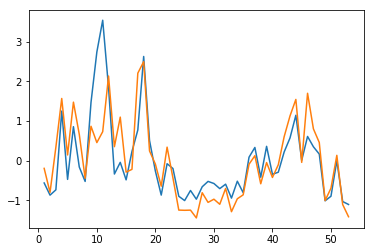

Done
('humidity', 'precipIntensity')
('humidity', 'temperature')
('humidity', 'uvIndex')
('humidity', 'visibility')
('humidity', 'windSpeed')
('precipIntensity', 'temperature')
('precipIntensity', 'uvIndex')
('precipIntensity', 'visibility')
('precipIntensity', 'windSpeed')
('temperature', 'uvIndex')
('temperature', 'visibility')
('temperature', 'windSpeed')
('uvIndex', 'visibility')
('uvIndex', 'windSpeed')
('visibility', 'windSpeed')


In [132]:
weather_total = pd.DataFrame()
weather_total = pd.concat(weather_list,ignore_index=True, sort=False)
weather_total.drop('Unnamed: 0', axis=1, inplace=True)

#weather_total.isnull().sum()
for col in weather_total.columns:
    if weather_total[col].isnull().sum() > 8000:
        weather_total.drop(col,axis=1, inplace=True)
        print('I dropped this feature:', col)
weather_total.columns

print(weather_total['icon'].unique(), weather_total['summary'].unique())
##Icon repeats summary so I will drop icon
#weather_total.drop('icon', axis=1, inplace=True)

numeric_columns = []
string_columns = []
for col in weather_total.columns:
    #if weather_total[col].dtypes == str:
    try:
        print(col, weather_total[col].max(), weather_total[col].min(), weather_total[col].mean())
        numeric_columns.append(col)
    except:
        print(col)
        string_columns.append(col)

for col in numeric_columns:
    weather_total[col].fillna(weather_total[col].bfill().ffill(), inplace=True)

weather_total.columns

weather_total['time'] = pd.to_datetime(weather_total['time'])
precip = weather_total.groupby(weather_total['time'].dt.week).agg({'precipIntensity': 'mean', 'precipProbability':'mean'})#.plot()


scaler = StandardScaler() 
  
# To scale data 
scaled_precip = scaler.fit_transform(precip)

plt.plot(precip.index, scaled_precip)
plt.show()
#Therefore I can drop precipProbablity
weather_total.drop('precipProbability', axis=1,inplace=True)
weather_total.columns
##I will leave also windspeed for wind data and temperature for temp
weather_total.drop(['windBearing', 'windGust', 'apparentTemperature', 'dewPoint'], axis=1,inplace=True)
#redefining numeric columns
numeric_columns = [x for x in weather_total.columns if x not in string_columns]
print('Done')
  
# Get all combinations of [1, 2, 3] 
# and length 2 
comb = combinations(list(weather_total[numeric_columns]), 2)
seed(1)
for x in comb:
    print(x)
# seed random number generator

# calculate Pearson's correlation
    corr, _ = pearsonr(weather_total[x[0]], weather_total[x[1]])
    if (corr > 0.8) or (corr <-0.8):
        print('Pearsons correlation: %.3f' % corr)
#No correlation: keep them all    

In [133]:
acc = pd.read_csv('total_accidents_2018.csv', encoding='utf-8')
acc['year'] = acc['year'].astype(int)
acc['month'] = acc['month_name'].apply(lambda x: mes_english_number(x))
acc['day_of_month'] = ['0' + x if len(x) == 1 else x for x in acc['day_month'].astype(int).astype(str)]
acc['hour'] = ['0' + x if len(x) == 1 else x for x in acc['hour_day'].astype(int).astype(str)]
acc['datetime'] = acc['year'].astype(str) +'-'+ acc['month'].astype(str)+ '-' + acc['day_of_month'] + " " + acc['hour']+':00:00'
weather_total['datetime'] = weather_total['time'].dt.strftime("%Y-%m-%d %H:%M:%S")
weather_total.to_csv('weather_bcn_2018.csv', encoding='utf-8')
accandweather = pd.merge(acc, weather_total,on='datetime',how='left')
accandweather.fillna(method='ffill',inplace=True)
accandweather.to_csv('accidents_and_weather2018.csv', encoding='utf-8')

In [14]:
import pickle
with open('soup_all_years_try.pkl', 'wb') as f:
    pickle.dump(soup, f)